#Multi-task learning

Multi-task learning (MTL) is a subfield of machine learning in which multiple learning tasks are solved at the same time, while exploiting commonalities and differences across tasks. This can result in improved learning efficiency and prediction accuracy for the task-specific models, when compared to training the models separately.

#Semi-supervised learning

Semi-supervised learning is a machine learning approach that utilizes both (small-scale) ***labeled*** data and (large-scale) ***unlabeled*** data. A teacher model is first trained with labeled data. Then the trained teacher model predicts the labels of unlabeled data. A student model is optimized to predict both the labels of labeled data and the pseudo-labels (the prediction by teacher) of unlabeled data.

#Knowledge expansion and distillation

The size of the student model is not necessarily smaller than the size of the teacher model. As a student model is exposed with larger-scale data with more difficult environments (noise), it can learn more information than the teacher model. One can interpret this method as ***knowledge expansion***.

On the other hand, we can also reduce the size of the student model for the sake of model compression. This process is called ***knowledge distillation*** and it is suitable for applications with less computing power.

In this example finetuned Huggingface audio classification model is used as a teacher.

[Distill Notebooks](https://github.com/42io/tflite_kws/blob/master/.github/jupyter/distill/)

In [1]:
TFLITE_MODEL_PATH = '/content/gdrive/MyDrive/0-9.distill.s2cnn13.tflite'
TOTAL_TRAINING_EPOCHS = 218
DS = {}

In [2]:
from google.colab import drive
drive.mount(TFLITE_MODEL_PATH[:15])

Mounted at /content/gdrive


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
from operator import itemgetter
print('TensorFlow', tf.__version__)
print('TensorFlow Datasets', tfds.__version__)
print('Numpy', np.__version__)
!python -V

TensorFlow 2.12.0
TensorFlow Datasets 4.9.2
Numpy 1.25.1
Python 3.10.12


In [4]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
resolver.get_tpu_system_metadata()

TPUSystemMetadata(num_cores=8, num_hosts=1, num_of_cores_per_host=8, topology=None, devices=(_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0), _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0), _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0), _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0), _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0), _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0), _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0), _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0), _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0), _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0), _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0), _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)))

In [5]:
GLOBAL_BATCH_SIZE = 32 * strategy.num_replicas_in_sync

In [6]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
  def __init__(
    self, learning_rate_base, total_steps, warmup_learning_rate, warmup_ratio
  ):
    super().__init__()

    self.learning_rate_base = learning_rate_base
    self.total_steps = total_steps
    self.warmup_learning_rate = warmup_learning_rate
    self.warmup_steps = int(total_steps * warmup_ratio)
    self.pi = tf.constant(np.pi)

  def __call__(self, step):
    if self.total_steps < self.warmup_steps:
      raise ValueError("Total_steps must be larger or equal to warmup_steps.")

    cos_annealed_lr = tf.cos(
      self.pi
      * (tf.cast(step, tf.float32) - self.warmup_steps)
      / float(self.total_steps - self.warmup_steps)
    )
    learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

    if self.warmup_steps > 0:
      if self.learning_rate_base < self.warmup_learning_rate:
        raise ValueError(
          "Learning_rate_base must be larger or equal to "
          "warmup_learning_rate."
        )
      slope = (
        self.learning_rate_base - self.warmup_learning_rate
      ) / self.warmup_steps
      warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
      learning_rate = tf.where(
        step < self.warmup_steps, warmup_rate, learning_rate
      )
    return tf.where(
      step > self.total_steps, 0.0, learning_rate, name="learning_rate"
    )

In [7]:
class Distiller(keras.Model):

  def __init__(self, student):
    super().__init__()
    self.student = student
    self.loss_tracker = keras.metrics.Mean(name='loss')

  @property
  def metrics(self):
    metrics = super().metrics
    metrics.append(self.loss_tracker)
    return metrics

  def compile(self, task_weight, temperature, **kwargs):
    super().compile(**kwargs)
    self.temperature = temperature
    self.task_weight = task_weight
    assert sum(task_weight) == 1

  def train_step(self, data_list):
    data_list = [itemgetter('mfcc', 'logits')(i) for i in data_list]

    with tf.GradientTape() as tape:
      loss = []

      for i, data in enumerate(data_list):
        # Unpack data
        x, teacher_predictions = data

        # Forward pass of student
        student_predictions = self.student(x, training=True)[i]

        # Compute losses
        loss.append(self.task_weight[i] * keras.losses.kld(
          tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
          tf.nn.softmax(student_predictions / self.temperature, axis=1),
        ) * self.temperature**2)

      loss = sum(loss)

    # Compute gradients
    trainable_vars = self.student.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

    # Update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # Report progress
    self.loss_tracker.update_state(loss)
    return {m.name: m.result() for m in self.metrics}

  def test_step(self, data_list):
    loss, metrics = [], []

    for i, data in enumerate(data_list):
      # Unpack data
      x, teacher_predictions, y = itemgetter('mfcc', 'logits', 'label')(data)

      # Forward pass of student
      student_predictions = self.student(x, training=False)[i]
      metrics.append((y, student_predictions))

      # Compute losses
      loss.append(self.task_weight[i] * keras.losses.kld(
        tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
        tf.nn.softmax(student_predictions / self.temperature, axis=1),
      ) * self.temperature**2)

    # Report progress
    self.loss_tracker.update_state(sum(loss))
    self.compiled_metrics.update_state(*zip(*metrics))
    return {m.name: m.result() for m in self.metrics}

In [8]:
def spectrogram_masking(spectrogram, dim, masks_number=2, mask_max_size=2):
  """Spectrogram masking on frequency or time dimension.
  Args:
    spectrogram: Input spectrum [batch, time, frequency]
    dim: dimension on which masking will be applied: 1 - time; 2 - frequency
    masks_number: number of masks
    mask_max_size: mask max size
  Returns:
    masked spectrogram
  """
  if dim not in (1, 2):
    raise ValueError('Wrong dim value: %d' % dim)
  input_shape = spectrogram.shape
  time_size, frequency_size = input_shape[1:3]
  dim_size = input_shape[dim]  # size of dimension on which mask is applied
  stripe_shape = [1, time_size, frequency_size]
  for _ in range(masks_number):
    mask_end = tf.random.uniform([], 0, mask_max_size, tf.int32)
    mask_start = tf.random.uniform([], 0, dim_size - mask_end, tf.int32)

    # initialize stripes with stripe_shape
    stripe_ones_left = list(stripe_shape)
    stripe_zeros_center = list(stripe_shape)
    stripe_ones_right = list(stripe_shape)

    # update stripes dim
    stripe_ones_left[dim] = dim_size - mask_start - mask_end
    stripe_zeros_center[dim] = mask_end
    stripe_ones_right[dim] = mask_start

    # generate mask
    mask = tf.concat((
        tf.ones(stripe_ones_left, spectrogram.dtype),
        tf.zeros(stripe_zeros_center, spectrogram.dtype),
        tf.ones(stripe_ones_right, spectrogram.dtype),
    ), dim)
    spectrogram = spectrogram * mask
  return spectrogram

In [9]:
def streaming_input_output(streaming, t, inputs, otputs, x):
  if streaming:
    otputs.append(x)
    x = keras.Input(shape=[t] + x.shape[2:])
    inputs.append(x)
  return x

In [10]:
def build_model(activation='elu', streaming=False):

  # resetting the layer name generation counter
  keras.backend.clear_session()

  inputs, outputs = [], []

  x = x_in = keras.Input(shape=(1 if streaming else 47, 13))

  x = keras.layers.Dense(512, use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.SpatialDropout1D(0.05)(x)

  for i in range(4):
    x = streaming_input_output(streaming, 1 + 2**i, inputs, outputs, x)
    x = keras.layers.Conv1D(x.shape[-1], 2,
                            dilation_rate=2**i, use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activation)(x)
    x = keras.layers.SpatialDropout1D(0.05)(x)

  x = streaming_input_output(streaming, 32, inputs, outputs, x)
  x = keras.layers.MaxPool1D(x.shape[1])(x)
  x = keras.layers.Flatten()(x)

  c = keras.layers.Dense(2 * x.shape[-1], use_bias=False)(x)
  c = keras.layers.BatchNormalization()(c)
  c = keras.layers.Activation(activation)(c)
  c = keras.layers.Dropout(0.05)(c)
  c = keras.layers.Dense(x.shape[-1], use_bias=False)(c)
  c = keras.layers.BatchNormalization()(c)
  c = keras.layers.add([c, x])
  c = keras.layers.Activation(activation)(c)
  c = keras.layers.Dropout(0.05)(c)
  c = keras.layers.Dense(12, name='c')(c)

  m = keras.layers.Dense(2 * x.shape[-1], use_bias=False)(x)
  m = keras.layers.BatchNormalization()(m)
  m = keras.layers.Activation(activation)(m)
  m = keras.layers.Dropout(0.05)(m)
  m = keras.layers.Dense(x.shape[-1], use_bias=False)(m)
  m = keras.layers.BatchNormalization()(m)
  m = keras.layers.add([m, x])
  m = keras.layers.Activation(activation)(m)
  m = keras.layers.Dropout(0.05)(m)
  m = keras.layers.Dense(2, name='m')(m)

  return keras.Model(inputs=[x_in] + inputs, outputs=[c, m] + outputs)

#Is Digit Mask Dataset

In [11]:
DS['mask-cv12'], info = tfds.load(
    name='my_dataset', split='train',
    data_dir='gs://tfds-isdigitensemble-cv12-mfcc.appspot.com',
    try_gcs=True, with_info=True)
assert info.homepage == 'https://huggingface.co/datasets/mazkooleg/digit_mask_ensemble_distilled_from_cv12_balanced_mfcc'
assert len(DS['mask-cv12']) == 10122488, len(DS['mask-cv12'])

In [12]:
(DS['mask-train'], DS['mask-test'], DS['mask-valid']), info = tfds.load(
    name='my_dataset', split=['train', 'test', 'valid'],
    data_dir='gs://tfds-isdigit-ensemble-ft-mfcc.appspot.com',
    try_gcs=True, with_info=True)
assert info.homepage == 'https://huggingface.co/datasets/mazkooleg/digit_mask_ft_ensemble_distilled_mfcc'
assert len(DS['mask-train']) == 1825800, len(DS['mask-train'])

In [13]:
print(int(DS['mask-test'].reduce(0, lambda x, y: x + int(y['label'] != tf.argmax(y['logits'])))),
      len(DS['mask-test']))

5 6086


In [14]:
print(int(DS['mask-valid'].reduce(0, lambda x, y: x + int(y['label'] != tf.argmax(y['logits'])))),
      len(DS['mask-valid']))

5 5276


In [15]:
DS['mask-train'] = DS['mask-train'].map(lambda d: {'mfcc': d['mfcc'], 'logits': d['logits']})
DS['mask-train'] = DS['mask-train'].concatenate(DS['mask-cv12'])
assert len(DS['mask-train']) == 11948288, len(DS['mask-train'])

# Digit 0-9up Dataset

In [16]:
DS['0-9up-cv12'], info = tfds.load(
    name='my_dataset', split='train',
    data_dir='gs://tfds-0-9up-ensemble-cv12-mfcc.appspot.com',
    try_gcs=True, with_info=True)
assert info.homepage == 'https://huggingface.co/datasets/mazkooleg/0-9up_ft_ensemble_distilled_from_cv12_balanced_mfcc'
assert len(DS['0-9up-cv12']) == 2056992, len(DS['0-9up-cv12'])

In [17]:
(DS['0-9up-train'], DS['0-9up-test'], DS['0-9up-valid']), info = tfds.load(
    name='my_dataset', split=['train', 'test', 'valid'],
    data_dir='gs://tfds-0-9up-ensemble-ft-mfcc.appspot.com',
    try_gcs=True, with_info=True)
assert info.homepage == 'https://huggingface.co/datasets/mazkooleg/0-9up-ft_ensemble_distilled_mfcc'
assert len(DS['0-9up-train']) == 1095480, len(DS['0-9up-train'])

In [18]:
print(int(DS['0-9up-test'].reduce(0, lambda x, y: x + int(y['label'] != tf.argmax(y['logits'])))),
      len(DS['0-9up-test']))

9 3773


In [19]:
print(int(DS['0-9up-valid'].reduce(0, lambda x, y: x + int(y['label'] != tf.argmax(y['logits'])))),
      len(DS['0-9up-valid']))

4 3368


In [20]:
DS['0-9up-train'] = DS['0-9up-train'].map(lambda d: {'mfcc': d['mfcc'], 'logits': d['logits']})
DS['0-9up-train'] = DS['0-9up-train'].concatenate(DS['0-9up-cv12'])
assert len(DS['0-9up-train']) == 3152472, len(DS['0-9up-train'])

# Multitask Distillattion

In [21]:
DS['0-9up-train'] = DS['0-9up-train'].cache().shuffle(len(DS['0-9up-train']))
DS['mask-train']  = DS['mask-train'].cache()
DS['train'] = tf.data.Dataset.zip((DS['0-9up-train'].repeat(), DS['mask-train']))
DS['valid'] = tf.data.Dataset.zip((DS['0-9up-valid'].repeat(), DS['mask-valid']))
DS['test']  = tf.data.Dataset.zip((DS['0-9up-test'].repeat(),  DS['mask-test']))
assert [len(DS[i]) for i in ('train', 'test', 'valid')] == [11948288, 6086, 5276]
DS['train'] = DS['train'].shuffle(len(DS['train']))
DS['train'] = DS['train'].batch(GLOBAL_BATCH_SIZE, drop_remainder=True)
DS['train'] = DS['train'].map(lambda *d: [i.update({'mfcc': spectrogram_masking(i['mfcc'], 1)}) or i for i in d])
DS['train'] = DS['train'].map(lambda *d: [i.update({'mfcc': spectrogram_masking(i['mfcc'], 2)}) or i for i in d])
DS['valid'] = DS['valid'].cache()
DS['test']  = DS['test'].cache()

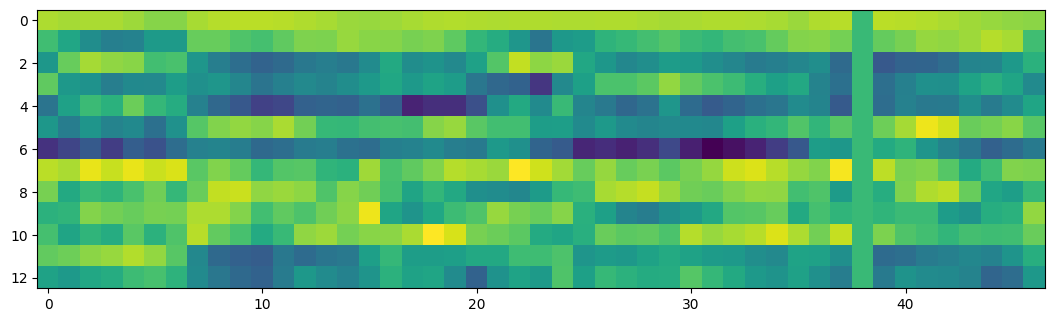

In [22]:
plt.rc('figure', figsize=(13, 4))
assert plt.imshow(next(iter(DS['train'].take(1)))[0]['mfcc'][0].numpy().T)

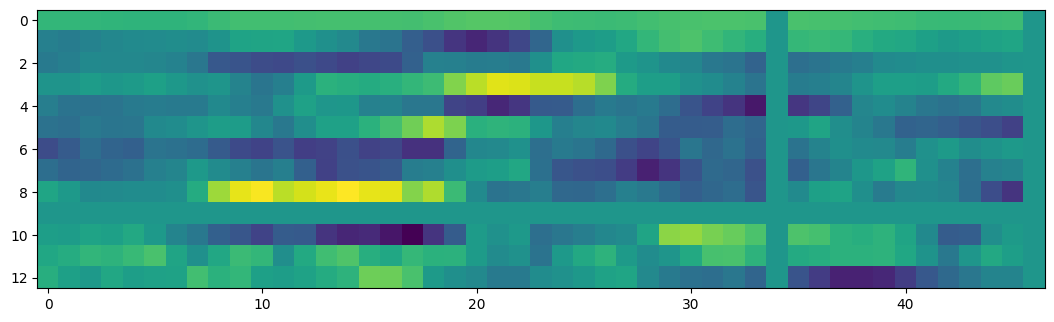

In [23]:
plt.rc('figure', figsize=(13, 4))
assert plt.imshow(next(iter(DS['train'].take(1)))[1]['mfcc'][0].numpy().T)

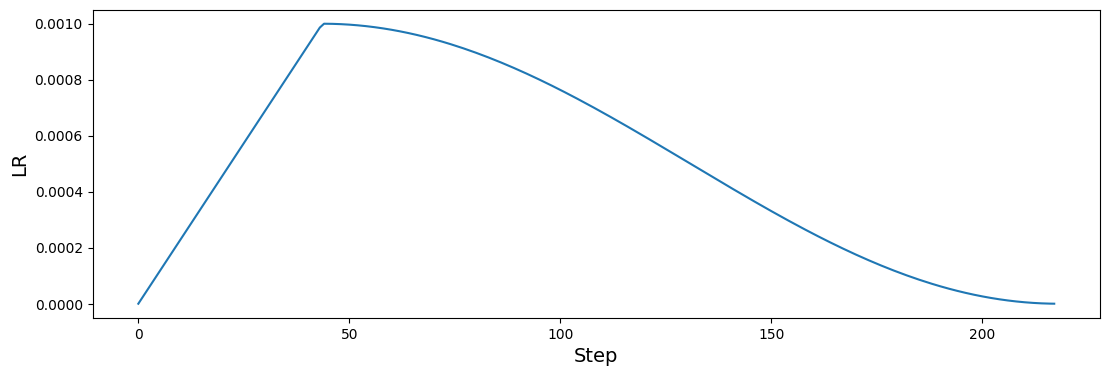

In [24]:
scheduled_lrs = WarmUpCosine(
  learning_rate_base=1e-3,
  total_steps=TOTAL_TRAINING_EPOCHS * len(DS['train']),
  warmup_learning_rate=0.0,
  warmup_ratio=0.2,
)

plt.plot([scheduled_lrs(step) for step in range(0, scheduled_lrs.total_steps,
                                                len(DS['train']))])
plt.xlabel("Step", fontsize=14)
assert plt.ylabel("LR", fontsize=14)

In [25]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 47, 13)]     0           []                               
                                                                                                  
 dense (Dense)                  (None, 47, 512)      6656        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 47, 512)     2048        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 47, 512)     0           ['batch_normalization[0][0]']

In [26]:
with strategy.scope():
  tpu_model = Distiller(keras.Model.from_config(model.get_config()))
  tpu_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=scheduled_lrs),
    metrics=[keras.metrics.SparseCategoricalAccuracy('acc')],
    temperature=10,
    task_weight=[0.9, 0.1],
    steps_per_execution=len(DS['train']))

In [27]:
# Distill teacher to student
history = tpu_model.fit(DS['train'],
                        validation_data=DS['valid'].repeat(
                            strategy.num_replicas_in_sync).batch(
                                GLOBAL_BATCH_SIZE, drop_remainder=True),
                        epochs=TOTAL_TRAINING_EPOCHS, verbose=2)

model.set_weights(tpu_model.student.get_weights())

Epoch 1/218
46673/46673 - 222s - loss: 2.2108 - val_output_1_acc: 0.9656 - val_output_2_acc: 0.9874 - val_loss: 0.8092 - 222s/epoch - 5ms/step
Epoch 2/218
46673/46673 - 196s - loss: 1.1008 - val_output_1_acc: 0.9845 - val_output_2_acc: 0.9915 - val_loss: 0.2812 - 196s/epoch - 4ms/step
Epoch 3/218
46673/46673 - 194s - loss: 0.8379 - val_output_1_acc: 0.9899 - val_output_2_acc: 0.9925 - val_loss: 0.1868 - 194s/epoch - 4ms/step
Epoch 4/218
46673/46673 - 196s - loss: 0.7241 - val_output_1_acc: 0.9910 - val_output_2_acc: 0.9923 - val_loss: 0.1567 - 196s/epoch - 4ms/step
Epoch 5/218
46673/46673 - 195s - loss: 0.6644 - val_output_1_acc: 0.9925 - val_output_2_acc: 0.9949 - val_loss: 0.1344 - 195s/epoch - 4ms/step
Epoch 6/218
46673/46673 - 193s - loss: 0.6271 - val_output_1_acc: 0.9925 - val_output_2_acc: 0.9949 - val_loss: 0.1220 - 193s/epoch - 4ms/step
Epoch 7/218
46673/46673 - 196s - loss: 0.6004 - val_output_1_acc: 0.9920 - val_output_2_acc: 0.9948 - val_loss: 0.1114 - 196s/epoch - 4ms/step

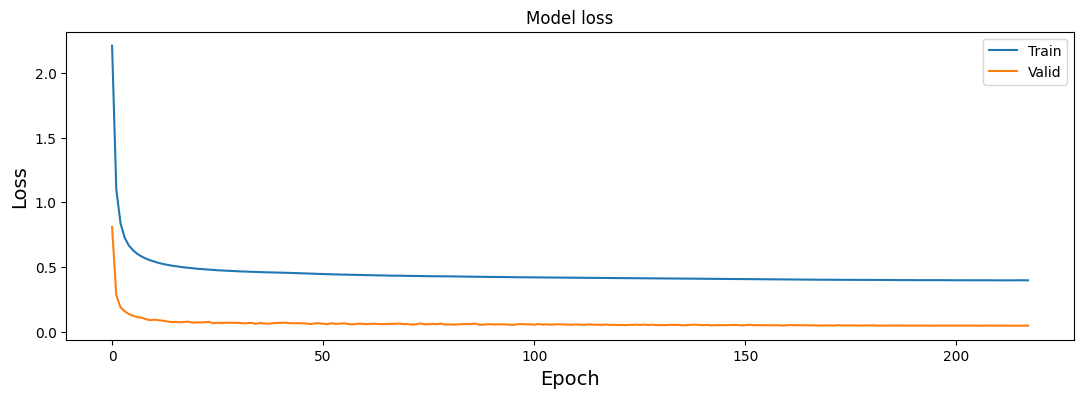

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
assert plt.legend(['Train', 'Valid'], loc='upper right')

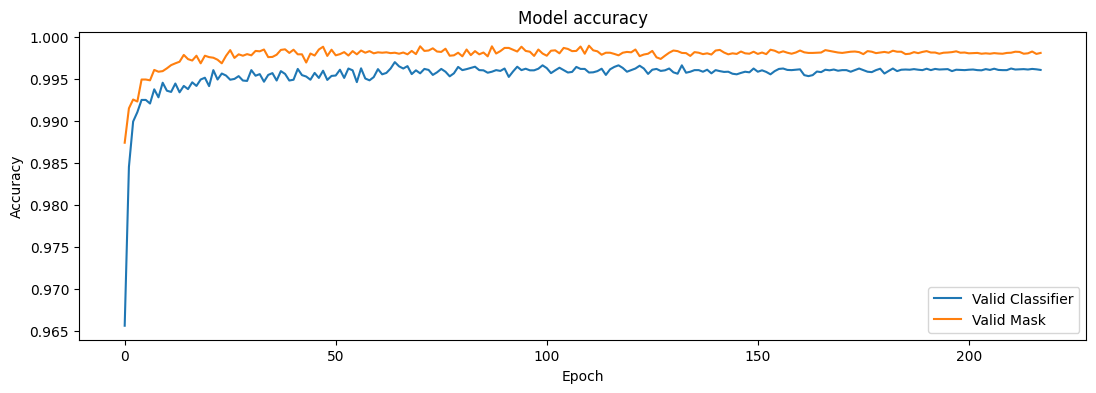

In [29]:
plt.plot(history.history['val_output_1_acc'])
plt.plot(history.history['val_output_2_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
assert plt.legend(['Valid Classifier', 'Valid Mask'], loc='lower right')

In [30]:
pred = model.predict(DS['test'].batch(32).map(lambda d, _: d['mfcc']), verbose=0)[0].argmax(axis=-1)
print(sum(1 for p, l in zip(pred, DS['test']) if p != l[0]['label']), len(pred))
pred = model.predict(DS['valid'].batch(32).map(lambda d, _: d['mfcc']), verbose=0)[0].argmax(axis=-1)
print(sum(1 for p, l in zip(pred, DS['valid']) if p != l[0]['label']), len(pred))

42 6086
21 5276


In [31]:
pred = model.predict(DS['test'].batch(32).map(lambda _, d: d['mfcc']), verbose=0)[1].argmax(axis=-1)
print(sum(1 for p, l in zip(pred, DS['test']) if l[1]['label'] and not p),
      sum(1 for p, l in zip(pred, DS['test']) if not l[1]['label'] and p), len(pred))
pred = model.predict(DS['valid'].batch(32).map(lambda _, d: d['mfcc']), verbose=0)[1].argmax(axis=-1)
print(sum(1 for p, l in zip(pred, DS['valid']) if l[1]['label'] and not p),
      sum(1 for p, l in zip(pred, DS['valid']) if not l[1]['label'] and p), len(pred))

7 9 6086
2 9 5276


# Target NN

In [32]:
def build_target_model():
  dest = build_model(streaming=True)
  for layer in dest.layers:
    if layer.get_weights():
      layer.set_weights(model.get_layer(name=layer.name).get_weights())
  i = [keras.Input(shape=i.shape[1:]) for i in dest.inputs]
  c, m, *x = dest(i)
  c, m = map(tf.math.softmax, [c, m])
  o = tf.concat([c[:,:10] * m[:,1:], c[:,10:]], axis=-1)
  o = tf.math.softmax(tf.math.log(o))
  return keras.Model(inputs=i, outputs=[o] + x, name='target')

In [33]:
streaming_model = build_target_model()
streaming_model.summary()

Model: "target"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1, 13)]      0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 2, 512)]     0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 3, 512)]     0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 5, 512)]     0           []                               
                                                                                             

In [34]:
with open('model.tflite', 'wb') as f:
  conv = tf.lite.TFLiteConverter.from_keras_model(streaming_model)
  conv.experimental_new_converter = False
  f.write(conv.convert())

In [35]:
!md5sum 'model.tflite'
!mv 'model.tflite' "$TFLITE_MODEL_PATH"

d5743f6a4053c68aad004c3babecf8c2  model.tflite
